# Segmenting and Clustering Neighborhoods in Toronto 

A notebook in which I will scrape data on postal codes in Toronto from Wikipedia, clean the data appropriately then load it into a dataframe. 

Once in a dataframe, I will gather data on the most common venues in each neighbourhood using the Foursquare API, and then use the K-nearest-neighbours algorithm to group the neighbourhoods together according to the different venue types. 

Finally, I will then visualise the results on a map. 



## Part 1. Data Scraping

In [1]:
# importing relevent packages: 

from bs4 import BeautifulSoup
import requests
import pandas as pd 
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.cm as cm
import folium
import matplotlib.colors as colors

### Scraping data from Wikipedia


Next, we will use the Request & BeautifulSoup libraries to access the HTML code containing data from the Wikipedia page, and then scrape the relevent data from the table. 

In [2]:
# Wikipedia link 
wiki_url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M" 

# Accessign page & converting HTML to a BeautifulSoup object
response = requests.get(wiki_url) 
soup = BeautifulSoup(response.text, 'html.parser') 

In [3]:
# Finding the table & isolataing table headers
table = soup.find('table')
table_headers = table.find_all('th') 
table_headers = [i.get_text().rstrip("\n") for i in table_headers] 
table_headers

['Postal Code', 'Borough', 'Neighbourhood']

In [4]:
# Isolataing table data & formatting data to a list 
table_data = table.find_all('td') 
table_data = [i.get_text().rstrip("\n") for i in table_data] 
table_data[:20]

['M1A',
 'Not assigned',
 'Not assigned',
 'M2A',
 'Not assigned',
 'Not assigned',
 'M3A',
 'North York',
 'Parkwoods',
 'M4A',
 'North York',
 'Victoria Village',
 'M5A',
 'Downtown Toronto',
 'Regent Park, Harbourfront',
 'M6A',
 'North York',
 'Lawrence Manor, Lawrence Heights',
 'M7A',
 'Downtown Toronto']

### Cleaning and loading data into a dataframe

Now that we have the data on each postal code & neighbourhood loaded into our notebook, lets perform some preliminary cleaning and load it into a pandas dataframe

In [5]:
# Seperating data into columns 
postal_code = [table_data[i] for i in range(0,len(table_data),3)] 
borough = [table_data[i+1] for i in range(0,len(table_data),3)] 
neighbourhood = [table_data[i+2] for i in range(0,len(table_data),3)] 
table_values2 = [postal_code, borough, neighbourhood] 

In [6]:
# Creating a dictionary object with headers and data together
headers_data = dict(zip(table_headers, table_values2)) 

# Creating dataframe 
df = pd.DataFrame(headers_data) 
df

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
...,...,...,...
175,M5Z,Not assigned,Not assigned
176,M6Z,Not assigned,Not assigned
177,M7Z,Not assigned,Not assigned
178,M8Z,Etobicoke,"Mimico NW, The Queensway West, South of Bloor,..."


In [7]:
# Dropping columns to which a borough is not assigned 
df = df.drop(df[df['Borough'] == 'Not assigned'].index).reset_index(drop = True) 

# Combining neighbourhoods that the same postcode
df = df.groupby(df['Postal Code']).agg('sum').reset_index() 
df

,Postal Code,Borough,Neighbourhood
0,M1B,Scarborough,"Malvern, Rouge"
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek"
2,M1E,Scarborough,"Guildwood, Morningside, West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
...,...,...,...
98,M9N,York,Weston
99,M9P,Etobicoke,Westmount
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ..."
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest..."


In [8]:
print("The dataframe has {} rows and {} columns".format(df.shape[0], df.shape[1]))

The dataframe has 103 rows and 3 columns


## Part 2: Adding Geocoding Data

Now that we have a list of all of our neighbourhoods and postal codes, we will add in latitude & longitude coordinates contained in a separate CSV file and merge this into our main dataframe

In [9]:
# Loading in the CSV file
lat_long = pd.read_csv("/Users/alexdelacey/Downloads/Geospatial_Coordinates.csv")

# Matching up indexes and concatinating dataframes
df.set_index('Postal Code')
lat_long.reindex(index=df['Postal Code'])
lat_long.reset_index()
df = pd.concat([df,lat_long],axis = 1)
df.head()


#Removing duplicate columns
df = df.loc[:,~df.columns.duplicated()]
df

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
...,...,...,...,...,...
98,M9N,York,Weston,43.706876,-79.518188
99,M9P,Etobicoke,Westmount,43.696319,-79.532242
100,M9R,Etobicoke,"Kingsview Village, St. Phillips, Martin Grove ...",43.688905,-79.554724
101,M9V,Etobicoke,"South Steeles, Silverstone, Humbergate, Jamest...",43.739416,-79.588437


As seen above, we now have a complete dataset ready for clustering analysis!

## Part 3: Using Fourspace API to get Venue Data

The following code will be used to get data on the top venues for each neighbourhood in Toronto. It will make a series of requests to the Fourspace API that will find the top 100 venues within each neighbourhood and return data on each venue including the geographical coordinates and the venue type. This will be added to a pandas dataframe. 

### Requesting data using the Foursquare API: 

In [10]:
CLIENT_ID = 'AMBG0WJK3FQ2NBDQNCXCSYOOKKLGDZG21H4DIO0OJKIZYJ3J' # Foursquare ID
CLIENT_SECRET = 'GVU3SMQJBDEIV4RIMIUYUKDTDM0WTPKXOWCLYZDGDVYOVECU' # Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
toronto_venues = getNearbyVenues(names = df['Neighbourhood'], 
                                   latitudes = df['Latitude'], 
                                    longitudes = df['Longitude'])

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [12]:
print("The venues dataframe has {} rows and {} columns.".format(toronto_venues.shape[0], toronto_venues.shape[1]))
toronto_venues.head()

The venues dataframe has 2167 rows and 7 columns.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.806686,-79.194353,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
2,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,SEBS Engineering Inc. (Sustainable Energy and ...,43.782371,-79.156820,Construction & Landscaping
3,"Guildwood, Morningside, West Hill",43.763573,-79.188711,RBC Royal Bank,43.766790,-79.191151,Bank
4,"Guildwood, Morningside, West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


### Hot-one encoding: 

Now, we will have to one hot encode each venue category, so the data is appropriately formatted for applying a cluster algorithm: 

In [13]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,...,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# Now, we will group the data by neighbourhood
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store
0,Agincourt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"Alderwood, Long Branch",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Bayview Village,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Displaying top 10 venues for each neighbourhood in a dataframe: 

In [15]:
# The code below sorts each venue in descending order, and then displays
# the top 10 venues for each neighbourhood in a dataframe

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Lounge,Skating Rink,Latin American Restaurant,Breakfast Spot,Clothing Store,Donut Shop,Discount Store,Distribution Center,Dive Bar,Dog Run
1,"Alderwood, Long Branch",Pizza Place,Pharmacy,Gym,Coffee Shop,Sandwich Place,Pub,Distribution Center,Dessert Shop,Dim Sum Restaurant,Diner
2,"Bathurst Manor, Wilson Heights, Downsview North",Coffee Shop,Bank,Chinese Restaurant,Bridal Shop,Sandwich Place,Diner,Restaurant,Deli / Bodega,Middle Eastern Restaurant,Supermarket
3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Diner,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop
4,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Greek Restaurant,Sushi Restaurant,Pharmacy,Pizza Place,Pub,Café,Restaurant
...,...,...,...,...,...,...,...,...,...,...,...
91,"Willowdale, Willowdale West",Pizza Place,Grocery Store,Coffee Shop,Butcher,Pharmacy,Greek Restaurant,Deli / Bodega,Eastern European Restaurant,Dumpling Restaurant,Drugstore
92,Woburn,Coffee Shop,Mexican Restaurant,Korean BBQ Restaurant,Women's Store,Donut Shop,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant
93,Woodbine Heights,Skating Rink,Park,Curling Ice,Beer Store,Intersection,Athletics & Sports,Dance Studio,Snack Place,Cosmetics Shop,Coworking Space
94,York Mills West,Park,Convenience Store,Women's Store,Donut Shop,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant


## Part 4: Exploration and Cluster Analysis

Now, we will use the k-means algorithm to cluster the neighbourhoods into 5 different groups according to the most popular venues

### K-nearest-neighbours clustering algorithm: 

In [16]:
# Number of clusters
k = 5 

# Dropping neighbourhoods column for clustering & fitting model: 
toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=k, random_state=8).fit(toronto_grouped_clustering)

# Counting neighbourhoods in each cluster: 
unique, counts = np.unique(kmeans.labels_, return_counts=True)
frequencies = np.asarray((unique, counts)).T

print("The frequencies for each cluster are as follows:\n", frequencies)

The frequencies for each cluster are as follows:
 [[ 0 29]
 [ 1  1]
 [ 2  9]
 [ 3  2]
 [ 4 55]]


### Creating a dataframe with cluster labels: 

Now, we will create a new dataframe that includes the cluster label and the top 10 venues for each neighbourhood. This is done through merging two of our dataframes

In [17]:
# add clustering labels
try: 
    neighborhoods_venues_sorted = neighborhoods_venues_sorted.drop(columns = 'Cluster Labels') 
except: 
    pass

neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df

toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

# Replacaing null values with 0 and changing the cluster labels to integer datatype: 
toronto_merged['Cluster Labels'] = toronto_merged['Cluster Labels'].fillna(0)
toronto_merged = toronto_merged.astype({'Cluster Labels': 'int32'})

## Part 5: Visualising Clusters on a Map: 

Now that we have clustered the neighbourhoods together, lets visualise the different clusters on a map

In [20]:
latitude, longitude = 43.6532, -79.3832

# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

And now we have a map that visualises different groups of neighbourhoods, grouped according to their most popular venues! 

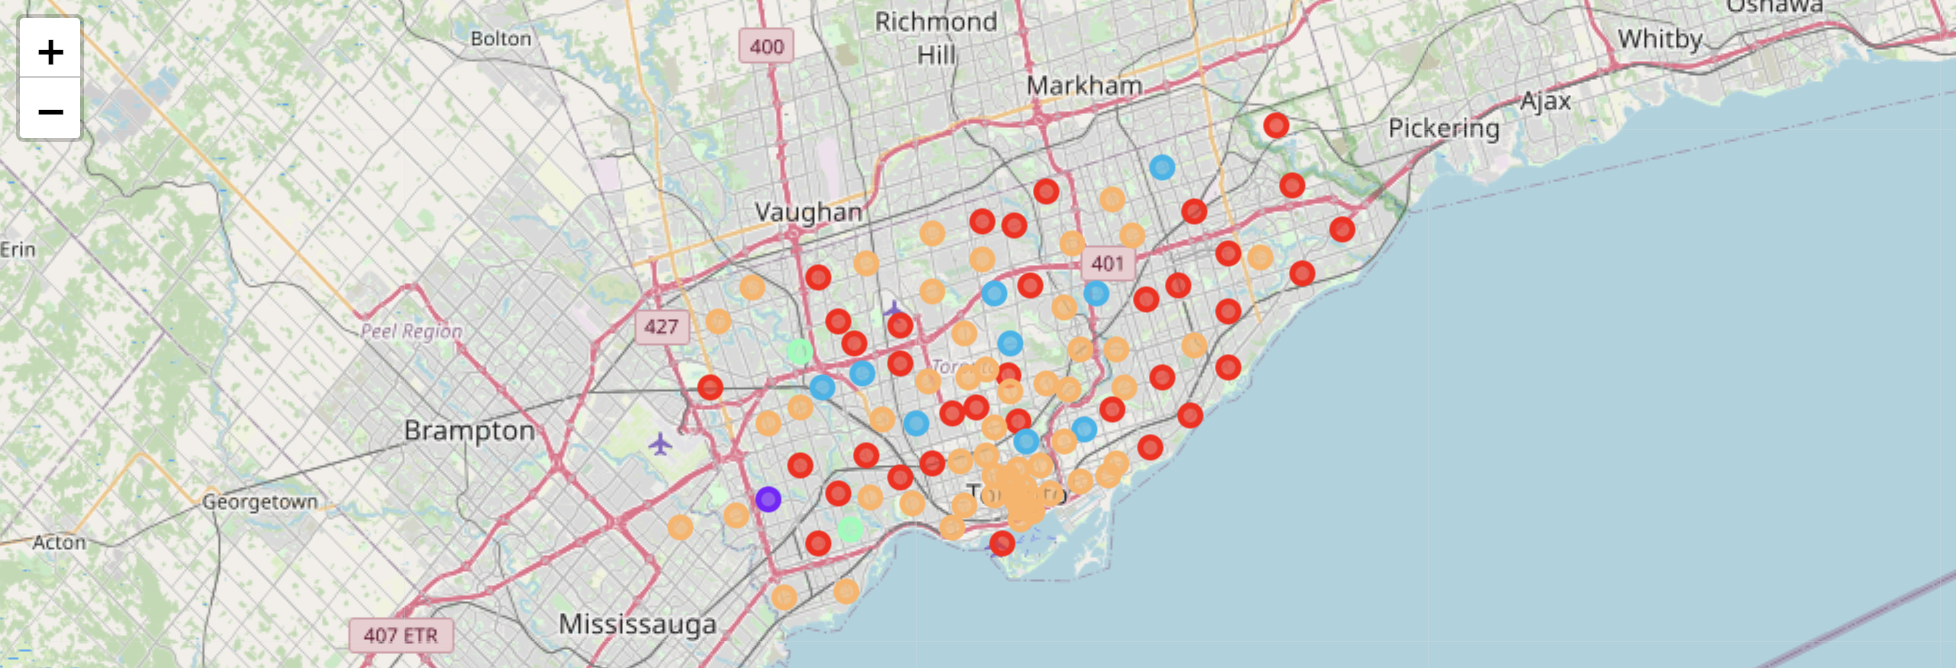

Screenshot if the map does not loaad properly